Given two measures $f^+$ and $f^-$ with equal mass, the [Monge-Kantorovich Equations](https://www.intlpress.com/site/pub/files/_fulltext/journals/cdm/1997/1997/0001/CDM-1997-1997-0001-a002.pdf) reads as finding the Kantorovich Potential $u^*$ and
the Optimal Transport Densisity $\mu^*$ solving the following system of PDE
$$
\nabla \cdot ( \mu^*(x) \nabla u^*(x) )= f^{+}(x)-f^{-}(x) \\
|\nabla u^*(x)|\leq 1 \\
|\nabla u^*(x)|=1 \mbox{\ where \ } \mu^*(x)>0. \\
$$
This is the PDE-based formulation of the Optimal Transport Problem with cost equal to the Euclidean distance.

In this notebook we reproduce Test-Case-1
[FaccaDaneriCardinPutti2020](https://link.springer.com/article/10.1007/s10915-020-01170-8).
where the problem is settled in the square $[0,1]\times[0,1]\subset R^2$ with $f^+$ and $f^-$
given by
$$
f^+(x)=2 \ \mbox{on}\  [1/8,3/8]\times [1/4,3/4] \\
f^-(x)=2 \ \mbox{on}\  [5/8,7/8]\times [1/4,3/4] \\
$$
and zero elsewhere.

We show how to pass the input data (triangulationed grid, forcings terms) and the algorithm controls to the dmk solver. Copy this notebook, change the triangulation and the measures $f^+$ and $f^-$ to run your own experiments.

In [1]:
# 
# Loading stardard and dmk pyhton modules
#

# Standard tools
import sys
import numpy as np


# Import I/O for timedata
try:
    sys.path.append('../../../../../globals/python/timedata/')
    import timedata as td
except:
    print("Global repo non found")

# Import geometry tools
sys.path.append('../../../../../geometry/python/')
import meshtools as mt
sys.path.append('../../../preprocess/assembly/')
import example_grid

# Import dmk tools
sys.path.append('../../')
import dmk_p1p0 
sys.path.append('../../../../build/python/fortran_python_interface/')
from dmk import (Dmkcontrols,  # controls for dmk simulations)
                 Timefunctionals # information of time/algorithm evolution
                )
# Import plot tools
import matplotlib.pyplot as plt

/home/fh/srcs/dmk_solver/globals/python_timedata
/home/fh/srcs/dmk_solver/otp_solver/python/examples/SegalaFacca
/home/fh/srcs/dmk_solver/otp_solver/preprocess/assembly
/home/fh/srcs/dmk_solver/build/python/fortran_python_interface


In [2]:
#
# Define mesh for spatial disctetization.
# Build the "coord" and "topol" numpy arrays describing coordinate and topology of the mesh.
#

# set mesh size 
ndiv=32
length=1.0/float(ndiv)
nref=0


# set grid example
flag_grid='rect_cnst'

# build grid using prebuild examples 
points, vertices, coord,topol,element_attributes = example_grid.example_grid(flag_grid,length)

# init fortran counterparts
[grid, subgrid]=dmk_p1p0.init_geometry(topol, coord, 1)

len_attributes 3174


In [3]:
#
# We create piecewise constant rapresentations of $f,f^+,f-$ and $\mu^*$,
# evaluating the function on cell centroids.
#


# define source and sink functions, value of grid centroids
def source(coord):
    x=coord[0]; y=coord[1]
    if ((x >= 1.0/8.0) and (x<=3.0/8.0) and
        (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
        fvalue=2.0
    else:
        fvalue=0.0
        
    return fvalue;

def sink(coord):
    x=coord[0]; y=coord[1]    
    if ((x >= 5.0/8.0) and (x<=7.0/8.0) and
        (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
        fvalue=2.0
    else:
        fvalue=0.0       
    return fvalue;
# For this case there exists an explicit solution of the Monge-Kantorivich equations:
# The optimal transport density:
def optimal_transport_density(coord):
    x=coord[0]; y=coord[1];
    if ((x >= 1.0/8.0) and (x<=3.0/8.0) and
        (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
        fvalue=(x-1.0/8.0)*2.0
    elif ((x >= 3.0/8.0) and (x<=5.0/8.0) and
          (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
        fvalue=(3.0/8.0-1.0/8.0)*2.0 
    elif ((x >= 5.0/8.0) and (x<=7.0/8.0) and
          (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
        fvalue=(7.0/8.0-x)*2.0
    else:
        fvalue=0.0
    return fvalue;
# exact wasserstein distance
exact_wass1=1.0/8.0


# and the Kantorovich potential
def kantorovich_potenial(coord):
    x=coord[0];        
    return -x;

# compute functions on cell centroids
ncell=len(topol)
bar_cell=mt.make_bar(coord,topol).transpose()
source_cell=np.zeros([ncell]); sink_cell=np.zeros([ncell]); opttdens_cell=np.zeros([ncell])
for i in range(ncell):
    source_cell[i] = source(bar_cell[:,i])
    sink_cell[i]   = sink(bar_cell[:,i])
    opttdens_cell[i] = optimal_transport_density(bar_cell[:,i])
forcing_cell=source_cell-sink_cell


# Init. inputs, set most of value to default (True) and assign remaing values
from dmk import Dmkinputsdata
dmkin=Dmkinputsdata.DmkInputs(); Dmkinputsdata.dmkinputs_constructor(dmkin,0,grid.ncell,subgrid.nnode,True)
dmkin=dmk_p1p0.set_forcing_term(dmkin,subgrid,forcing_cell)
dmkin.direction=-1.0 # ascending direction
dmkin.pflux = 2.0
dmkin.pode  = 1.0
dmkin.pmass = 1.0

print(dmkin.direction)


-1.0


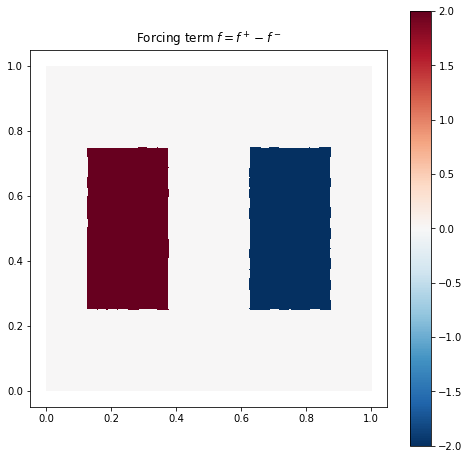

In [4]:
import matplotlib.tri as mtri
#
# plot forcing term
#
triang = mtri.Triangulation(coord.transpose()[0,:], coord.transpose()[1,:], topol)
fig1, ax1 = plt.subplots(figsize=(8, 8)); ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, forcing_cell , cmap='RdBu_r')
fig1.colorbar(tpc)
ax1.set_title('Forcing term $f=f^+-f^-$')
plt.show()


We load the controls from file. You can either change it in the file or change some controls in the next cell.

In [5]:
# init from file from file
ctrl = dmk_p1p0.init_dmkctrl(explicit_implicit='explicit',tdens_gfvar='tdens')

# The user can change any controls inside the ctrl type.
# Here we set the saving frequency (save all) and the convergence tolerance
ctrl.id_save_dat=1
ctrl.fn_tdens='tdens.dat'
ctrl.fn_pot='pot.dat'
ctrl.fn_statistics='dmk.log'

ctrl.outer_max_iter=1000

ctrl.max_time_iterations=1000

ctrl.deltat_control=2
ctrl.deltat=0.001
ctrl.deltat_expansion_rate=1.05
ctrl.deltat_upper_bound=0.1

ctrl.user_system_variation=0

ctrl.tolerance_system_variation=1e-4

In [6]:
from dmk import Dmkp1P0Discretization


# Init spatial discrteization
p1p0=Dmkp1P0Discretization.dmkp1p0()
Dmkp1P0Discretization.dmkp1p0_constructor(p1p0,ctrl,1,grid,subgrid)

# work copy
Dmkcontrols.dmkctrl_constructor(ctrl)
work_ctrl = Dmkcontrols.DmkCtrl()
Dmkcontrols.dmkctrl_copy(ctrl,work_ctrl)

In [7]:
# Init solution container to default
tdpot=dmk_p1p0.init_tdpot(grid.ncell,subgrid.nnode)

In [8]:
from dmk import Dmkp1P0Discretization
timefun=Timefunctionals.evolfun()
Timefunctionals.evolfun_constructor(timefun, 0,
                                    ctrl.max_time_iterations,
                                    ctrl.max_nonlinear_iterations)

info=0
# (re)init 
tdpot=dmk_p1p0.init_tdpot(grid.ncell,subgrid.nnode)



# solve with dmk
info=np.zeros(1,dtype=np.int8)
flag=np.ones(1,dtype=np.int8)
flag_task=np.ones(1,dtype=np.int8)
current_time=np.zeros(1)
dmkin.steady=True

while ( flag > 0 ):
    Dmkp1P0Discretization.dmkp1p0_cycle_reverse_communication(p1p0,
                                                              flag,flag_task,info,
                                                              current_time,
                                                        dmkin,tdpot,ctrl,work_ctrl)
    if ( flag[0] == 2 ):
        #            
        # Fill dmk inputs with data (rhs, kappa, beta, etc)
        # at current time
        #
        dmkin.time=current_time                     
    elif( flag[0] == 3 ):           
        # 
        # Right before new update when tdpot and inputs_data are syncronized.
        # The user can compute print any information regarding
        # the state of the system
        print(tdpot.system_variation)
        
    elif( flag[0] == 4 ):           
        # 
        # Optional: user-defined evaluation of steady state
        # User must set flag "user_system_variation=1"
        # in controls
        ctrl.user_system_variation=0
        #tdpot.system_variation=np.linalg.norm(1.0/tdpot.tdens-1.0/tdpot.tdens_old)/(
        #        ctrl.deltat*np.linalg.norm(1.0/tdpot.tdens_old))
   
    elif( flag[0] == 5 ):           
        # 
        # Optional: user-defined set the controls for the next update
        # User must set flag "user_control_set=1"
        #ctrl.deltat=1.05*ctrl.deltat
        #
        ctrl.user_control_set=0
        #print('new deltat', ctrl.deltat)
    elif( flag[0] == 6 ):           
        # 
        # Optional: reset controls after update failure 
        # User must set flag "user_control_reset=1"
        ctrl.user_control_reset=1
        ctrl.deltat=0.5*ctrl.deltat
        print('new deltat', ctrl.deltat)

print(info)

1.0000000150474662e+30
0.8527228977000479
0.8528426723041413
0.8529680019186608
0.853099122132264
0.8532362763398853
0.8533797157780705
0.853529699533242
0.8536864945197637
0.8538503754243473
0.8540216246133092
0.8542005319987698
0.8543873948596807
0.854582517613784
0.8547862115360034
0.8549987944188565
0.8552205901703255
0.8554519283445624
0.8556931436012534
0.8559445750885384
0.8562065657454846
0.8564794615196168
0.856763610496486
0.8570593619364744
0.857367065217241
0.8576870686785125
0.8580197183685153
0.8583653566911172
0.858724320954309
0.8590969418222932
0.8594835416736042
0.8598844328721452
0.8602999159552815
0.8607302777509309
0.8611757894315427
0.8616367045215597
0.8621132568705062
0.8626056586131651
0.8631140981334054
0.8636387380558306
0.864179713283434
0.8647371290999677
0.8653110593386013
0.8659015445753714
0.866508590100024
0.8671321621371603
0.8677721685664175
0.8684284039897887
0.8691007519451758
0.8697890955854399
0.8704685612300053
0.871133633216769
0.871784836501866

0.9528135428290125
0.9529083135661572
0.9530028525368598
0.9530971612572661
0.9531912412529419
0.9532850939523204
0.9533787208126789
0.9534721232747921
0.9535653027156801
0.953658260545462
0.9537509982141871
0.9538435168260408
0.9539358177385243
0.9540279033141559
0.9541197726752197
0.954211428877769
0.954302872579042
0.9543941050836978
0.9544851275943312
0.9545759412876357
0.954666547348878
0.9547569469341076
0.9548471411815652
0.9549371312108562
0.9550269181292769
0.955116503023388
0.955205886990335
0.9552950709693694
0.9553840561160333
0.9554728433950127
0.9555614338064242
0.9556498283338114
0.9557380279441164
0.955826033569259
0.9559138461293953
0.9560014666023038
0.9560888958063415
0.9561761346605754
0.9562631840243706
0.9563500447405545
0.9564367176351785
0.9565232035448159
0.9566095032583687
0.9571884915931594
0.9567817048288979
0.9568674455816126
0.9569530031540999
0.9570383782710018
0.957123571727858
0.9572085842264516
0.9572934167314908
0.9573780685734348
0.957462541924983
0.

0.9135842206527508
0.9138733385147643
0.9141610210745874
0.914447273741435
0.9147321016249907
0.9150155095246517
0.9152975019160215
0.9155780829370911
0.9158572563791451
0.9161350256892878
0.9164113939947902
0.9166863641609118
0.9169599388915581
0.91723212087353
0.9175029129491216
0.9177723182832825
0.918040340481719
0.9183069836251679
0.9185722522121657
0.9188361510334633
0.9190986850185754
0.9193598590930738
0.9196196780709365
0.9198781465906076
0.92013526909244
0.9203910498312138
0.9206454929157326
0.9208986023684532
0.9211503821972314
0.9214008364703291
0.9216499693849665
0.9218977853196274
0.9221442888638968
0.9223894848227906
0.9226333781987257
0.9228759741579532
0.9231172779896687
0.9233572950653169
0.9235960308035727
0.9238334906434041
0.9240696800260836
0.9243046043845169
0.9245382691391139
0.9247706796975891
0.9250018414581049
0.925231759813658
0.9254604401574923
0.9256878878885618
0.9259141084168545
0.9261391071682241
0.926362889588767
0.9265854611484854
0.9268068273445214
0

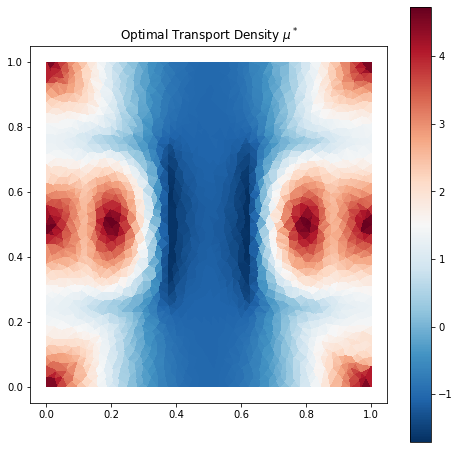

In [9]:
import matplotlib.tri as mtri
# plot forcing term
triang = mtri.Triangulation(coord.transpose()[0,:], coord.transpose()[1,:], topol)
fig1, ax1 = plt.subplots(figsize=(8, 8)); ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, np.log(tdpot.tdens) , cmap='RdBu_r')
fig1.colorbar(tpc)
ax1.set_title('Optimal Transport Density $\mu^*$')
plt.show()

0


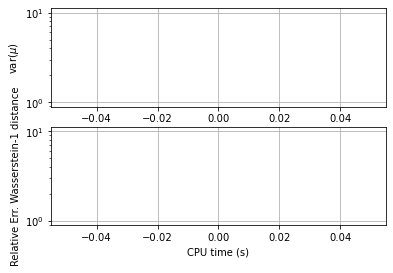

In [10]:
# plot convergence toward steady state
print(timefun.last_time_iteration)
time      = np.array(timefun.time[0:timefun.last_time_iteration]);
cpu_time  = np.array(timefun.cpu_time[0:timefun.last_time_iteration])
var_tdens = np.array(timefun.var_tdens[1:timefun.last_time_iteration])
wass1     = np.array(timefun.lyapunov[1:timefun.last_time_iteration])
errwass1=(wass1[:]-exact_wass1)/(exact_wass1)

plt.figure(1)
plt.subplot(211)
plt.yscale('log')
plt.ylabel('var($\mu$)')
plt.xlabel('CPU time (s)')
plt.grid(True)
plt.plot(cpu_time[1:], var_tdens, 'bo--')

plt.subplot(212)
plt.yscale('log')
plt.ylabel('Relative Err. Wasserstein-1 distance')
plt.xlabel('CPU time (s)')
plt.grid(True)
plt.plot(cpu_time[1:], errwass1, 'ro--')
plt.show()

In [11]:
import pyvtk

[topol_sub,coord_sub]=dmk_p1p0.getgeometry(subgrid)
[topol,coord]=dmk_p1p0.getgeometry(grid)

coord_sub=coord_sub.transpose()
coord=coord.transpose()

vtk = pyvtk.VtkData(pyvtk.UnstructuredGrid(points=coord_sub,triangle=topol_sub),
                    pyvtk.PointData(pyvtk.Scalars(tdpot.pot,name='OptPot')),
                    'OptPot')
vtk.tofile('OptPot.vtk')

vtk = pyvtk.VtkData(pyvtk.UnstructuredGrid(points=coord,triangle=topol),
                    pyvtk.CellData(pyvtk.Scalars(tdpot.tdens,name='OptTdens')),
                    'OptTdens')
vtk.tofile('OptTdens.vtk')